In [1]:
import os
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT
from stellargraph import StellarGraph
from sklearn import model_selection
from collections import Counter
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
data_directory = os.path.expanduser("/home/ronaldsonbellande/Desktop/Data Mining/project/cora/")

In [3]:
data_list = pd.read_csv(os.path.join(data_directory, "cora.cites"), sep='\t', header=None, names=["target", "source"])
data_list_content = os.path.join(data_directory, "cora.content")

In [4]:
cora_feature_names = [f"w{i}" for i in range(1433)]

In [5]:
cora_content_data = pd.read_csv(
    data_list_content,
    sep="\t",  
    header=None,
    names=["id", *cora_feature_names, "subject"],
)
cora_content_str_subject = cora_content_data.set_index("id")
cora_content_no_subject = cora_content_str_subject.drop(columns="subject")
cora_content_no_subject

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w1423,w1424,w1425,w1426,w1427,w1428,w1429,w1430,w1431,w1432
id,,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1061127,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1128977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1128978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
cora_dataset_no_subject = StellarGraph({"paper": cora_content_no_subject}, {"cites": data_list})
print(cora_dataset_no_subject.info())
cora_dataset_no_subject

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [7]:
cora_dataset_subject = cora_content_str_subject["subject"]
cora_dataset_subject

id
31336             Neural_Networks
1061127             Rule_Learning
1106406    Reinforcement_Learning
13195      Reinforcement_Learning
37879       Probabilistic_Methods
                    ...          
1128975        Genetic_Algorithms
1128977        Genetic_Algorithms
1128978        Genetic_Algorithms
117328                 Case_Based
24043             Neural_Networks
Name: subject, Length: 2708, dtype: object

In [8]:
train_subjects, test_subjects = model_selection.train_test_split(
    cora_dataset_subject, train_size=140, test_size=None, stratify=cora_dataset_subject
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [9]:
Counter(train_subjects)

Counter({'Case_Based': 16,
         'Genetic_Algorithms': 22,
         'Probabilistic_Methods': 22,
         'Rule_Learning': 9,
         'Theory': 18,
         'Neural_Networks': 42,
         'Reinforcement_Learning': 11})

In [10]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [11]:
generator = FullBatchNodeGenerator(cora_dataset_no_subject, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)

In [12]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [13]:
x_inp, predictions = gat.in_out_tensors()

In [14]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [15]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [16]:
es_callback = EarlyStopping(monitor="val_acc", patience=20)

mc_callback = ModelCheckpoint("best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True)

In [17]:
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  
    callbacks=[es_callback, mc_callback],
)

Epoch 1/50
1/1 - 8s - loss: 1.9801 - acc: 0.1429 - val_loss: 1.8361 - val_acc: 0.3940
Epoch 2/50
1/1 - 1s - loss: 1.8166 - acc: 0.2929 - val_loss: 1.7348 - val_acc: 0.4300
Epoch 3/50
1/1 - 0s - loss: 1.6837 - acc: 0.4286 - val_loss: 1.6467 - val_acc: 0.4480
Epoch 4/50
1/1 - 0s - loss: 1.6219 - acc: 0.4714 - val_loss: 1.5676 - val_acc: 0.4820
Epoch 5/50
1/1 - 0s - loss: 1.5233 - acc: 0.5357 - val_loss: 1.4962 - val_acc: 0.5200
Epoch 6/50
1/1 - 0s - loss: 1.3725 - acc: 0.6071 - val_loss: 1.4295 - val_acc: 0.5680
Epoch 7/50
1/1 - 0s - loss: 1.3023 - acc: 0.5786 - val_loss: 1.3664 - val_acc: 0.5960
Epoch 8/50
1/1 - 0s - loss: 1.2133 - acc: 0.6357 - val_loss: 1.3050 - val_acc: 0.6320
Epoch 9/50
1/1 - 0s - loss: 1.2068 - acc: 0.6643 - val_loss: 1.2467 - val_acc: 0.6660
Epoch 10/50
1/1 - 0s - loss: 1.1485 - acc: 0.7000 - val_loss: 1.1926 - val_acc: 0.6920
Epoch 11/50
1/1 - 0s - loss: 1.0343 - acc: 0.7429 - val_loss: 1.1424 - val_acc: 0.7160
Epoch 12/50
1/1 - 0s - loss: 1.0207 - acc: 0.7357 - 

In [18]:
def plot_training_data(model_details):
    plt.plot(model_details.history['acc'])
    plt.plot(model_details.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'Validation'], loc='upper left')
    plt.grid()
    plt.savefig('/home/ronaldsonbellande/Desktop/Data Mining/project/GAT/model_accuracy.png', dpi =500) 
    plt.show()
    plt.plot(model_details.history['loss'])
    plt.plot(model_details.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'Validation'], loc='upper left')
    plt.grid()
    plt.savefig('/home/ronaldsonbellande/Desktop/Data Mining/project/GAT/model_loss.png', dpi =500) 
    plt.show()

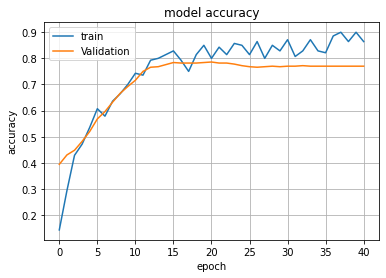

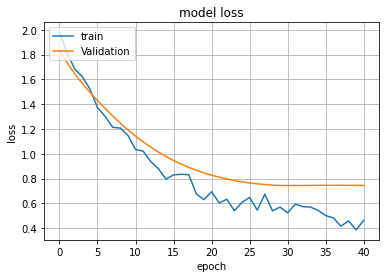

In [19]:
plot_training_data(history)

In [20]:
model.load_weights("best_model.h5")

In [21]:
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 83ms/step - loss: 0.7975 - acc: 0.7834
	loss: 0.7975
	acc: 0.7834


In [22]:
all_nodes = cora_dataset_subject.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [23]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [24]:
df = pd.DataFrame({"Predicted": node_predictions, "True": cora_dataset_subject})
df

,Predicted,True
id,,
31336,Neural_Networks,Neural_Networks
1061127,Theory,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
...,...,...
1128975,Genetic_Algorithms,Genetic_Algorithms
1128977,Genetic_Algorithms,Genetic_Algorithms
1128978,Genetic_Algorithms,Genetic_Algorithms


In [25]:
emb_layer = next(l for l in model.layers if l.name.startswith("graph_attention"))

In [26]:
embedding_model = Model(inputs=x_inp, outputs=emb_layer.output)
emb = embedding_model.predict(all_gen)

In [27]:
X = emb.squeeze()
y = np.argmax(target_encoding.transform(cora_dataset_subject), axis=1)

In [28]:
if X.shape[1] > 2:
    transform = TSNE

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=list(cora_dataset_no_subject.nodes()))
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(cora_dataset_no_subject.nodes()))
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

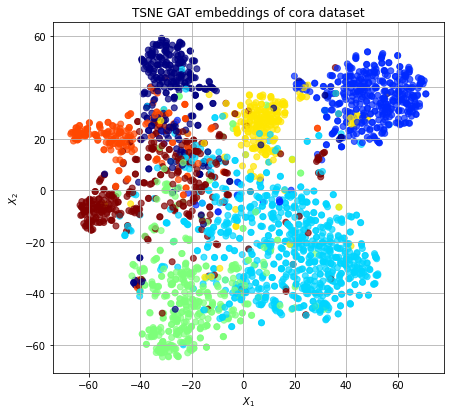

In [29]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("{} GAT embeddings of cora dataset".format(transform.__name__))
plt.grid()
plt.savefig('/home/ronaldsonbellande/Desktop/Data Mining/project/GAT/GAT embeddings.png', dpi =500) 
plt.show()